In [ ]:
import xarray as xr


dem_folder = '/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/dem'
slope_50m_filename = dem_folder + '/'+'SLP_MSF_UTM32_50m_bilinear.tif'
slope_375m_bilinear_filename = dem_folder + '/'+'SLP_MSF_UTM32_375m_bilinear.tif'
slope_375m_lanczos_filename = dem_folder + '/'+'SLP_MSF_UTM32_375m_lanczos.tif'

slope_50m = xr.open_dataset(slope_50m_filename)
slope_375m_bilinear= xr.open_dataset(slope_375m_bilinear_filename)
slope_375m_lanczos= xr.open_dataset(slope_375m_lanczos_filename)

In [17]:
from xarray.groupers import BinGrouper
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def percentage(dataset: xr.Dataset, tot: int):
    return dataset.count() / tot *100

def percentage_large_dataset(dataset: xr.Dataset, grouper: BinGrouper) -> xr.Dataset:
    out_das = []
    for idx in tqdm(range(0,len(dataset.x.values), 5000)):
        out_das.append(dataset.isel(x=slice(idx,idx+5000)).groupby(band_data=grouper).count())
    res = xr.concat(out_das, dim='new_dim').sum('new_dim') / dataset.count() * 100
    return res

tot_pixels = slope_375m_bilinear.count()
slope_group = BinGrouper(np.arange(20,80, 20))
bil_df = slope_375m_bilinear.groupby(band_data=slope_group).map(percentage, tot=slope_375m_bilinear.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'bilinear'}) 
df_lanc = slope_375m_lanczos.groupby(band_data=slope_group).map(percentage, tot=slope_375m_lanczos.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'lanczos'})  
ref_df = percentage_large_dataset(slope_50m, grouper=slope_group).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'reference DEM 50 m'})
combined_1 = bil_df.assign(lanczos=df_lanc, ref_50m = ref_df)
slope_group = BinGrouper(np.arange(10,80, 20))
bil_df = slope_375m_bilinear.groupby(band_data=slope_group).map(percentage, tot=slope_375m_bilinear.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'bilinear'}) 
df_lanc = slope_375m_lanczos.groupby(band_data=slope_group).map(percentage, tot=slope_375m_lanczos.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'lanczos'})  
ref_df = percentage_large_dataset(slope_50m, grouper=slope_group).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'reference DEM 50 m'})
combined_2 = bil_df.assign(lanczos=df_lanc, ref_50m = ref_df)
slope_group = BinGrouper(np.arange(20,80, 10))
bil_df = slope_375m_bilinear.groupby(band_data=slope_group).map(percentage, tot=slope_375m_bilinear.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'bilinear'}) 
df_lanc = slope_375m_lanczos.groupby(band_data=slope_group).map(percentage, tot=slope_375m_lanczos.count()).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'lanczos'})  
ref_df = percentage_large_dataset(slope_50m, grouper=slope_group).drop_vars('spatial_ref').to_pandas().rename(columns={'band_data': 'reference DEM 50 m'})
combined_3 = bil_df.assign(lanczos=df_lanc, ref_50m = ref_df)

100%|██████████| 5/5 [00:46<00:00,  9.33s/it]


<Axes: xlabel='band_data_bins', ylabel='% pixels'>

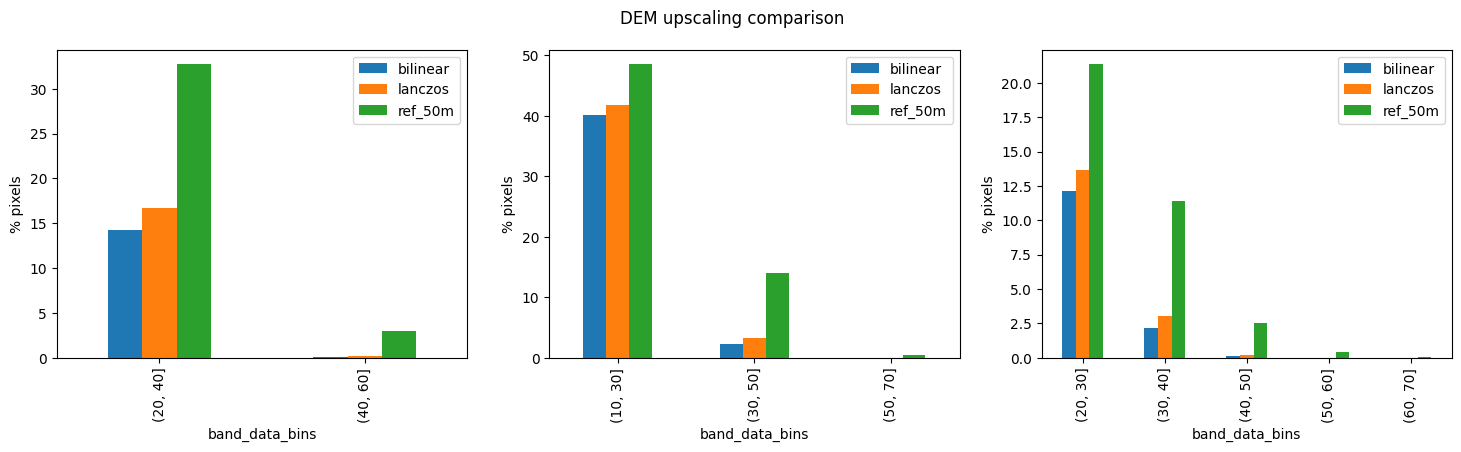

In [18]:
figs, axs = plt.subplots(1,3, figsize=(18,4))
figs.suptitle('DEM upscaling comparison')
[ax.set_xlabel('slope %') for ax in axs]
[ax.set_ylabel('% pixels') for ax in axs]
combined_1.plot.bar(ax=axs[0])
combined_2.plot.bar(ax=axs[1])
combined_3.plot.bar(ax=axs[2])